In [2]:
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
# from google.colab import drive
# drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
!pip uninstall opencv-python -y

!pip install opencv-contrib-python==3.4.2.17 --force-reinstall


Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 106kB/s 
     |████████████████████████████████| 20.2MB 76.5MB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [0]:
# import zipfile
# with zipfile.ZipFile("/content/drive/My Drive/BDMH_PROJECT/brain-mri-images-for-brain-tumor-detection.zip","r") as zip_ref:
#     zip_ref.extractall("/content/drive/My Drive/BDMH_PROJECT/dataset_bdmh_braintumor")

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import random
from sklearn.svm import SVC
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:

#input_path = "/content/drive/My Drive/BDMH_PROJECT/dataset_bdmh_braintumor"
input_path="Datasets"
CATEGORIES = ["no", "yes"]

In [0]:

def create_training_data():
    training_data = []
    for category in CATEGORIES:
        path = os.path.join(input_path, category)
        category_index = CATEGORIES.index(category)
        for image in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
                #img_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_REDUCED_GRAYSCALE_2)
                
                img_array = img_array.astype(np.float32)
                img_array = cv2.resize(img_array, (128,128))
                training_data.append([img_array, category_index])
            except Exception as e:
                print(e)
    return training_data    

training_data=create_training_data()
random.shuffle(training_data)

(253, 128, 128)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 155, 1: 155})
(310, 16384)
(310, 128, 128)


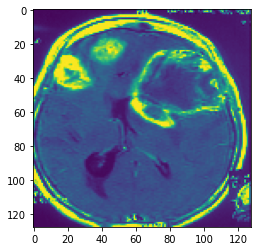

In [35]:
#print(training_data[0])


data_set = []
data_label = []
for feature,label in training_data:
  data_set.append(feature)
  data_label.append(label)


plt.imshow(data_set[132])
data_set=np.array(data_set)
data_set=data_set/255.0
print(data_set.shape)

data_set_flatten=data_set.reshape(data_set.shape[0],data_set.shape[1]*data_set.shape[1])


oversample = SMOTE()
data_set_flatten, data_label = oversample.fit_resample(data_set_flatten, data_label)
data_set=data_set_flatten.reshape(data_set_flatten.shape[0],data_set.shape[1],data_set.shape[1])


counter=Counter(data_label)
print(counter)

print(data_set_flatten.shape)
print(data_set.shape)


In [0]:
def get_hog(train_images_temp):
  hog_features_train=[]
  for i in range(0,len(train_images_temp)):
      fd = hog(train_images_temp[i],orientations=8,pixels_per_cell=(16,16),cells_per_block=(2,2),block_norm='L2')
      hog_features_train.append(fd)


  hog_features_train=np.array(hog_features_train)

  return hog_features_train


In [0]:
def get_surf(images, name='surf', save=False):
    # SURF descriptor for 1 image
    def get_image_surf(image, vector_size=8):
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        alg = cv2.xfeatures2d.SURF_create()
        kps = alg.detect(image, None)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 128)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
            
        return dsc
    
    # SURF descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_surf(img)
        features.append(dsc)
    
    result = np.array(features)
        
    return result



In [0]:
def get_sift(images, name='sift'):
    # SIFT descriptor for 1 image
    def get_image_sift(image, vector_size=8):
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        alg = cv2.xfeatures2d.SIFT_create()
        kps = alg.detect(image, None)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 128
        needed_size = (vector_size * 128)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
            
        return dsc
    
    # SIFT descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_sift(img)
        features.append(dsc)

    result = np.array(features)
        
    return result

In [0]:

def get_kaze(images, name='kaze', save=False):
    # KAZE descriptor for 1 image
    def get_image_kaze(image, vector_size=32):
        alg = cv2.KAZE_create()
        kps = alg.detect(image)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
        return dsc
    
    # KAZE descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_kaze(img)
        features.append(dsc)
    
    result = np.array(features)
    return result

In [36]:
train_data_hog=get_hog(data_set)
train_data_sift=get_sift(data_set)
train_data_surf=get_surf(data_set)
train_data_kaze=get_kaze(data_set)
print(train_data_hog.shape)
print(train_data_sift.shape)
print(train_data_surf.shape)
print(train_data_kaze.shape)

(310, 1568)
(310, 1024)
(310, 1024)
(310, 2048)


In [33]:
data_set_hog=get_hog(data_set)
data_set_hog.shape

(310, 9248)

In [0]:
X_train1,X_test1,y_train1,y_test1=train_test_split(train_data_hog,data_label,test_size=0.2,random_state=42)
X_train2,X_test2,y_train2,y_test2=train_test_split(train_data_sift,data_label,test_size=0.2,random_state=42)
X_train3,X_test3,y_train3,y_test3=train_test_split(train_data_surf,data_label,test_size=0.2,random_state=42)
X_train4,X_test4,y_train4,y_test4=train_test_split(train_data_kaze,data_label,test_size=0.2,random_state=42)
X_train5,X_test5,y_train5,y_test5=train_test_split(data_set_flatten,data_label,test_size=0.2,random_state=42)

In [67]:
random_forest_list=[]
random_forest_list1=[]
model1=RandomForestClassifier()
model2=RandomForestClassifier()
model3=RandomForestClassifier()
model4=RandomForestClassifier()
model5=RandomForestClassifier()
model1=model1.fit(X_train1,y_train1)
model2=model2.fit(X_train2,y_train2)
model3=model3.fit(X_train3,y_train3)
model4=model4.fit(X_train4,y_train4)
model5=model5.fit(X_train5,y_train5)

random_forest_list1.append(model1.score(X_train1,y_train1))
random_forest_list1.append(model2.score(X_train2,y_train2))
random_forest_list1.append(model3.score(X_train3,y_train3))
random_forest_list1.append(model4.score(X_train4,y_train4))
random_forest_list1.append(model5.score(X_train5,y_train5))
#print("Using Random Forest and hog Transformation",model1.score(X_test1,y_test1))
random_forest_list.append(model1.score(X_test1,y_test1))
random_forest_list.append(model2.score(X_test2,y_test2))
random_forest_list.append(model3.score(X_test3,y_test3))
random_forest_list.append(model4.score(X_test4,y_test4))
random_forest_list.append(model5.score(X_test5,y_test5))
print(random_forest_list)
print(random_forest_list1)

[0.8709677419354839, 0.6774193548387096, 0.6935483870967742, 0.7580645161290323, 0.8870967741935484]
[1.0, 1.0, 1.0, 1.0, 1.0]


In [65]:
random_forest_list=[]
random_forest_list1=[]
model1=SVC()
model2=SVC()
model3=SVC()
model4=SVC()
model5=SVC()
model1=model1.fit(X_train1,y_train1)
model2=model2.fit(X_train2,y_train2)
model3=model3.fit(X_train3,y_train3)
model4=model4.fit(X_train4,y_train4)
model5=model5.fit(X_train5,y_train5)

random_forest_list1.append(model1.score(X_train1,y_train1))
random_forest_list1.append(model2.score(X_train2,y_train2))
random_forest_list1.append(model3.score(X_train3,y_train3))
random_forest_list1.append(model4.score(X_train4,y_train4))
random_forest_list1.append(model5.score(X_train5,y_train5))
#print("Using Random Forest and hog Transformation",model1.score(X_test1,y_test1))
random_forest_list.append(model1.score(X_test1,y_test1))
random_forest_list.append(model2.score(X_test2,y_test2))
random_forest_list.append(model3.score(X_test3,y_test3))
random_forest_list.append(model4.score(X_test4,y_test4))
random_forest_list.append(model5.score(X_test5,y_test5))
print(random_forest_list)
print(random_forest_list1)

[0.8709677419354839, 0.5806451612903226, 0.7741935483870968, 0.7258064516129032, 0.8387096774193549]
[0.9193548387096774, 0.9153225806451613, 0.8306451612903226, 0.9798387096774194, 0.9395161290322581]


In [57]:
random_forest_list=[]
random_forest_list1=[]
model1=XGBClassifier()
model2=XGBClassifier()
model3=XGBClassifier()
model4=XGBClassifier()
model5=XGBClassifier()


model1=model1.fit(X_train1,y_train1)
model2=model2.fit(X_train2,y_train2)
model3=model3.fit(X_train3,y_train3)
model4=model4.fit(X_train4,y_train4)
model5=model5.fit(X_train5,y_train5)

random_forest_list1.append(model1.score(X_train1,y_train1))
random_forest_list1.append(model2.score(X_train2,y_train2))
random_forest_list1.append(model3.score(X_train3,y_train3))
random_forest_list1.append(model4.score(X_train4,y_train4))
random_forest_list1.append(model5.score(X_train5,y_train5))
#print("Using Random Forest and hog Transformation",model1.score(X_test1,y_test1))
random_forest_list.append(model1.score(X_test1,y_test1))
random_forest_list.append(model2.score(X_test2,y_test2))
random_forest_list.append(model3.score(X_test3,y_test3))
random_forest_list.append(model4.score(X_test4,y_test4))
random_forest_list.append(model5.score(X_test5,y_test5))
print(random_forest_list)
print(random_forest_list1)

[0.9032258064516129, 0.6290322580645161, 0.6935483870967742, 0.7258064516129032, 0.9032258064516129]
[1.0, 1.0, 1.0, 1.0, 1.0]


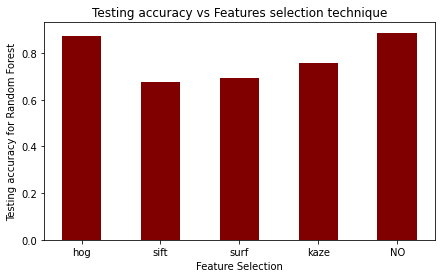

In [68]:
fig = plt.figure(figsize = (7, 4)) 
courses=['hog','sift','surf','kaze','NO']
# creating the bar plot 
plt.bar(courses, random_forest_list, color ='maroon',  
        width = 0.5) 
  
plt.xlabel("Feature Selection") 
plt.ylabel("Testing accuracy for Random Forest") 
plt.title("Testing accuracy vs Features selection technique") 
plt.show() 

In [0]:
#CNN

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [0]:
#VGG-16 CNN Model

def CNN_VGG16_model():
  inputs=keras.Input(shape=(data_set.shape[1],data_set.shape[1],1),dtype=tf.float32)
  x=inputs

  x=keras.layers.Conv2D(16,(3,3),activation='relu')(x)
  x=keras.layers.Conv2D(16,(3,3),activation='relu')(x)
  x=keras.layers.MaxPooling2D((2,2))(x)

  x=keras.layers.Conv2D(32,(3,3),activation='relu')(x)
  x=keras.layers.Conv2D(32,(3,3),activation='relu')(x)
  x=keras.layers.MaxPooling2D((2,2))(x)

  x=keras.layers.Conv2D(64,(3,3),activation='relu')(x)
  x=keras.layers.Conv2D(64,(3,3),activation='relu')(x)
  x=keras.layers.Conv2D(64,(3,3),activation='relu')(x)
  x=keras.layers.MaxPooling2D((2,2))(x)

  x=keras.layers.Conv2D(128,(3,3),activation='relu')(x)
  x=keras.layers.Conv2D(128,(3,3),activation='relu')(x)
  x=keras.layers.Conv2D(128,(3,3),activation='relu')(x)
  x=keras.layers.MaxPooling2D((2,2))(x)

  # x=keras.layers.Conv2D(256,(3,3),activation='relu')(x)
  # x=keras.layers.Conv2D(256,(3,3),activation='relu')(x)
  # x=keras.layers.Conv2D(256,(3,3),activation='relu')(x)
  # x=keras.layers.MaxPooling2D((2,2))(x)


  x=keras.layers.Flatten()(x)
  x=keras.layers.Dense(100,activation='relu')(x)
  x=keras.layers.Dense(20,activation='relu')(x)
  
  output=keras.layers.Dense(1,activation='tanh')(x)
  model=keras.Model(inputs=inputs,outputs=output,name='CNN_VGG16_Model')
  return model

In [82]:
data_label=np.array(data_label)
data_set=np.array(data_set)
vgg_model=CNN_VGG16_model()
vgg_model.summary()
es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=6)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
vgg_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
first_nn_fitted=vgg_model.fit(data_set,data_label,validation_split=0.2,epochs=40,verbose=1,callbacks=[es,mc])

Model: "CNN_VGG16_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 126, 126, 16)      160       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 60, 60, 32)        4640      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 29, 29, 32)    

In [0]:

def base_model_func1():
  inputs=keras.Input(shape=(data_set.shape[1],data_set.shape[1],1),dtype=tf.float32)
  x=inputs
  x=keras.layers.Conv2D(64,(3,3),activation='relu')(x)
  x=keras.layers.Conv2D(64,(3,3),activation='relu')(x)
  x=keras.layers.MaxPooling2D((2,2))(x)
  #x=keras.layers.Dropout(0.4)(x)
  x=keras.layers.Conv2D(128,(3,3),activation='relu')(x)
  x=keras.layers.Conv2D(128,(3,3),activation='relu')(x)
  x=keras.layers.MaxPooling2D((2,2))(x)
  #x=keras.layers.Dropout(0.4)(x)
  
  # x=keras.layers.Conv2D(128,(3,3),activation='relu')(x)
  # x=keras.layers.Conv2D(128,(3,3),activation='relu')(x)
  # x=keras.layers.MaxPooling2D((2,2))(x)
  #x=keras.layers.Dropout(0.4)(x)

  x=keras.layers.Flatten()(x)
  x=keras.layers.Dense(20,activation='relu')(x)
  # x=keras.layers.Dropout(0.2)(x)
  # x=keras.layers.Dense(25,activation='relu')(x)
  #x=keras.layers.Dense(8,activation='relu')(x)
  output=keras.layers.Dense(1,activation='tanh')(x)
  model=keras.Model(inputs=inputs,outputs=output,name='CNN_base_model')
  return model


In [72]:
#data_set=data_set.reshape(data_set.shape[0],data_set.shape[1]*data_set.shape[1])

data_label=np.array(data_label)
base_model=base_model_func1()
base_model.summary()
es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
base_model.compile(optimizer='adam',loss='squared_hinge',metrics=['accuracy'])
first_nn_fitted=base_model.fit(data_set,data_label,validation_split=0.2,epochs=40,verbose=1,callbacks=[es,mc])

Model: "CNN_base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 128)    

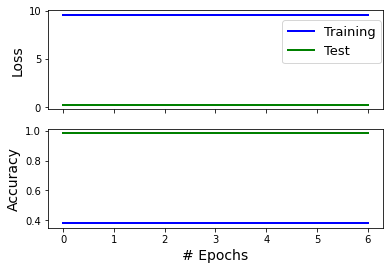

In [83]:
#PLOTTING EPOCHS VS LOSS AND ACCURCY FOR BASE MODELS
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(len(first_nn_fitted.history['loss'])), first_nn_fitted.history['loss'],linestyle='-', color='blue',label='Training', lw=2)
ax1.plot(range(len(first_nn_fitted.history['val_loss'])), first_nn_fitted.history['val_loss'], linestyle='-', color='green',label='Test', lw=2)
ax2.plot(range(len(first_nn_fitted.history['accuracy'])), first_nn_fitted.history['accuracy'],linestyle='-', color='blue',label='Training', lw=2)
ax2.plot(range(len(first_nn_fitted.history['val_accuracy'])), first_nn_fitted.history['val_accuracy'], linestyle='-', color='green',label='Test', lw=2)
leg = ax1.legend(bbox_to_anchor=(0.7, 0.9), loc=2, borderaxespad=0.,fontsize=13)
ax1.set_xticklabels('')
#ax1.set_yscale('log')
ax2.set_xlabel('# Epochs',fontsize=14)
ax1.set_ylabel('Loss',fontsize=14)
ax2.set_ylabel('Accuracy',fontsize=14)
plt.show()